# Cat vs. Dog

## Import

- pandas: To sotre dataset in a pandas DataFrame.
- numpy: To resize, normalize and store each image.
- Image: To get the images (dataset).
- os: To get the image files.
- plt: To plot the results.
- tensorflow: To construct a model.

In [9]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In this cell, we set seeds to 42 so that in different executions, the results won't change.

In [10]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

- As we can see, for instance there are 350 image of cats in train set.
- There are 247 different shapes of these images.
- So we have to resize them all to a certain size, so that we can train a model.

In [11]:
# Directory path containing cats images as train data
cats_train_directory = './HW2_Dataset/Train/Cats'

# All files in the input directory
cats_train_files = [file for file in os.listdir(cats_train_directory) if file.endswith(('.jpg'))]

# shapes of images in train cat set
shapes = [Image.open(os.path.join(cats_train_directory, img)).size for img in cats_train_files]

print(f"There are {len(cats_train_files)} cat images as train data.")
print(f"And there are {len(set(shapes))} different shapes for these images.")

There are 350 cat images as train data.
And there are 247 different shapes for these images.


## Preprocessing

### Resize and Normalize

- Using `resize_normalize()` function, an image is given,
- And the normalized (pixels in range [0, 1]),
- And also resized to a certain target_size.

In [12]:
def resize_normalize(image_path, target_size):
    # Open the image using PIL
    img = Image.open(image_path)
    # Resize the image to the target size
    img = img.resize(target_size)
    # Convert the image to a NumPy array
    img_array = np.array(img)
    # Normalize the pixel values
    img_array = img_array / 255.0

    return img_array

- Using `preprocessing()` function,
- All .jpg files in a certain directory will stored.
- Normalize and resize each image.
- Return the final DataFrame which contains the image arrays.

In [13]:
def preprocessing(directory_path, target_size=(224, 224)):
    # All files in the input directory
    image_files = [file for file in os.listdir(directory_path) if file.endswith(('.jpg'))]
    # The DataFrame which the data will be stored in
    data = pd.DataFrame(columns=['image_array'])

    image_array = []

    # Iterate through each image file
    for image in image_files:
        # Construct the full path for the input image
        image_path = os.path.join(directory_path, image)
        # Preprocess the image
        processed_image = resize_normalize(image_path, target_size)
        # Update the DataFrame
        new_data = pd.DataFrame({'image_array': [processed_image]})
        data = pd.concat([data, new_data], ignore_index=True)

    return data

- Get all the images (train and test).
- As we can see, 
    - We have 350 cat images in train set.
    - 352 dog images in train set.
    - 50 dog images in test set.
    - 50 cat images in test set.
- After resize and normalization, all the images will be in shape **(224, 224, 3)**.

In [14]:
# get all the data and store in dataframes
train_cat = preprocessing('./HW2_Dataset/Train/Cats')
test_cat = preprocessing('./HW2_Dataset/Test/Cats')
train_dog = preprocessing('./HW2_Dataset/Train/Dogs')
test_dog = preprocessing('./HW2_Dataset/Test/Dogs')

print(f"number of cats in train set: {train_cat.shape[0]}")
print(f"number of cats in test set: {test_cat.shape[0]}")
print(f"number of dogs in train set: {train_dog.shape[0]}")
print(f"number of dogs in test set: {test_dog.shape[0]}")
print(f"shape of all images: {train_cat.iloc[0]['image_array'].shape}")

number of cats in train set: 350
number of cats in test set: 50
number of dogs in train set: 352
number of dogs in test set: 50
shape of all images: (224, 224, 3)


### Set targets

- Set the target for each images (0 for cats, 1 for dogs).
- Concatenate train set and test set. (with shuffling).

In [15]:
train_cat['pet'] = 0
test_cat['pet'] = 0
train_dog['pet'] = 1
test_dog['pet'] = 1

random_state = 42

# append the test and train data to each other and shuffle
train_raw = pd.concat([train_cat, train_dog]).sample(frac=1, random_state=random_state).reset_index(drop=True)
test_raw = pd.concat([test_cat, test_dog]).sample(frac=1, random_state=random_state).reset_index(drop=True)

- As in the given article, the train set is splited to train and validation (70, 30 respectively).
- The data is stored in such a way that we can use it to train a tensor model.
- So we have train set with **491**.
- Validation set with **211**.
- And test set with **100** images.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Split the train set to train and validation
X_train, X_val, y_train, y_val = train_test_split(np.stack(train_raw['image_array'].values), train_raw['pet'].values, test_size=0.3, random_state=42)

X_test = np.stack(test_raw['image_array'].values)
y_test = test_raw['pet'].values

## Model training

Set the hyperparameters as in the article.
- learning rate = 0.1
- batch size = 10
- number of epochs = 25
- momentum = 0.9
- learning rate decay = 0.002

I have set number of epochs to **25**, so that run freezed and unfreezed model each with 25 epochs (50 epochs in total).

In [ ]:
# Define hyperparameters
lr = 0.1
batch_size = 10
num_epochs = 25
momentum = 0.9
lr_decay = 0.002

## Augmentation

- We are using `ImageDataGenerator` from keras preprocessing for data augmentation.
- Parameters are set as in the article:
    - horizontal flip: randomly flip the images horizontaly.
    - rotation_range: rotate the images randomly in range [-30, 30] degrees clockwise and counterclockwise.
    - scale: zoom in and zoom out with scale range [0.75, 1.25]
- Create the augmentation using `flow()`.
- some example of data augmentation is shown in below.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

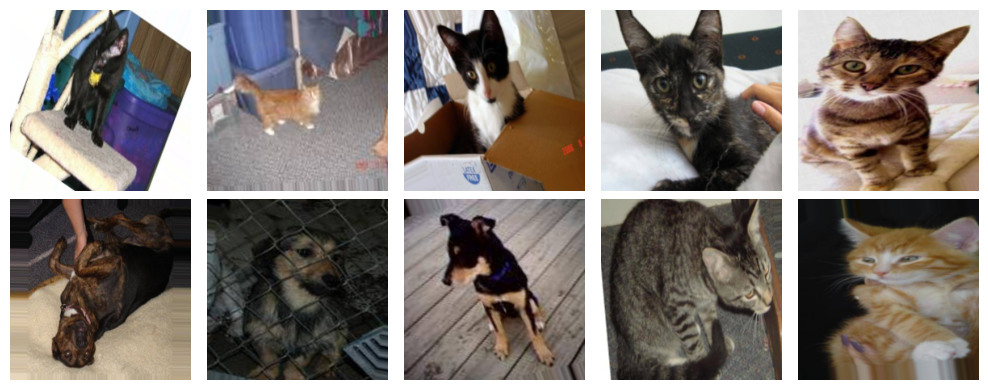

In [ ]:
# Create an ImageDataGenerator instance for augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=30,
                                   zoom_range=[0.75, 1.25],
                                   fill_mode='nearest')

# Flow training data from generator
augmentation = train_datagen.flow(X_train, y_train,
                                  batch_size=batch_size)

# Visualize some of the augmented images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()

for i in range(10):
    augmented_images, _ = augmentation.next()
    axes[i].imshow(augmented_images[0])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## VGG16

- VGG16 is imported as a backbone model.
- Different kind of keras layers are imported as well.
- SGD is used as an optimizer.

In [136]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers.legacy import SGD

This the defenition of the model we are defining with VGG16 as ity's backbone:

- VGG16 itself gets the normalized data with specifice size. (the fully connected isn't included)
- Flat the output of last convolutional block of vgg16.
- Batch Normalization.
- A dense layer with 512 neurons inside. Activation function is set to **ReLU**.
- Dropout with 20% rate.
- Another dense layer with 512 neurons inside. Activation function is set to **ReLU**.
- Dropout with 20% rate.
- Batch Normalization.
- The output layer contating only one neuron. Activation function is set to **Sigmoid**.

In [ ]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add fully connected layers
x = Flatten()(vgg16_base.output)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
FC_out_vgg16 = Dense(1, activation='sigmoid')(x)

### Augmented Data VGG16

#### Freezed VGG16

- Freeze the base vgg16 model.
- Define the model.
- As we can see, this model have 27,925,825 parameters in total.
- The added fully connected part have 13,159,937 parameters.

In [ ]:
vgg16_base.trainable = False
# Create the new model
vgg16_model_aug = Model(inputs=vgg16_base.input, outputs=FC_out_vgg16)

vgg16_model_aug.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

At first, we compile the model:
- Optimizer: optimizer is set to SGD with defined parameters as the article. 
    - learning rate = 0.1
    - momentum = 0.9
    - learning rate decay = 0.002
- loss: the loss function is set to binary cross entropy.
    - loss function is set to categorical cross entropy, but as the target values are binary, so the binary cross entropy would be a better loss function.
- metrics: accuracy.

Then we train the model:
- The iput data is the augmented data using `ImageDataGenerator`.
- number of epochs,
- batch size,
- and validation set is given.

In [ ]:
# Compile the model
vgg16_model_aug.compile(optimizer=SGD(learning_rate=lr, momentum=momentum, decay=lr_decay),
                         loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_vgg16_aug = vgg16_model_aug.fit(augmentation, epochs=num_epochs,
                                        validation_data=(X_val, y_val),
                                        batch_size=batch_size)

Epoch 1/25
50/50 [==============================] - 10s 186ms/step - loss: 3.5907 - accuracy: 0.6558 - val_loss: 14.2599 - val_accuracy: 0.5071
Epoch 2/25
50/50 [==============================] - 8s 152ms/step - loss: 3.0748 - accuracy: 0.6986 - val_loss: 2.2024 - val_accuracy: 0.6682
Epoch 3/25
50/50 [==============================] - 7s 141ms/step - loss: 1.1354 - accuracy: 0.7800 - val_loss: 2.8080 - val_accuracy: 0.6209
Epoch 4/25
50/50 [==============================] - 9s 171ms/step - loss: 0.8194 - accuracy: 0.8045 - val_loss: 0.4158 - val_accuracy: 0.8626
Epoch 5/25
50/50 [==============================] - 7s 144ms/step - loss: 0.6182 - accuracy: 0.7800 - val_loss: 0.4691 - val_accuracy: 0.8246
Epoch 6/25
50/50 [==============================] - 8s 153ms/step - loss: 0.3518 - accuracy: 0.8534 - val_loss: 0.3868 - val_accuracy: 0.8483
Epoch 7/25
50/50 [==============================] - 8s 163ms/step - loss: 0.3608 - accuracy: 0.8595 - val_loss: 0.3529 - val_accuracy: 0.8294
Epoc

4/4 [==============================] - 0s 97ms/step - loss: 0.2964 - accuracy: 0.8900
Test accuracy: 0.8899999856948853
Test loss: 0.29641684889793396


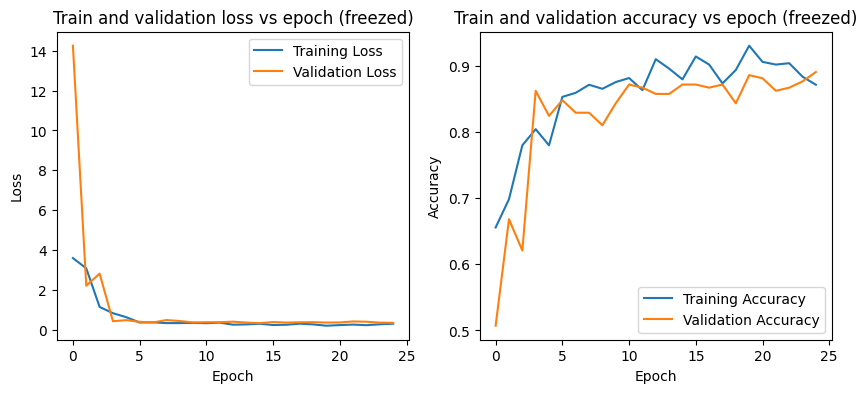

In [ ]:
# Evaluate the model using test set
test_loss, test_acc = vgg16_model_aug.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}\nTest loss: {test_loss}')

# Plot the loss and accuracy per epoch for train and validation set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(history_vgg16_aug.history['loss'], label='Training Loss')
axes[0].plot(history_vgg16_aug.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title("Train and validation loss vs epoch (freezed)")
axes[0].legend()

axes[1].plot(history_vgg16_aug.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_vgg16_aug.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title("Train and validation accuracy vs epoch (freezed)")
axes[1].legend()

plt.show()

As we can see based on training history in freeze training:
- Training accuracy is about 93% at best.
- Validation accuracy is about 89.1%.
- Test accuracy is also about 89%.

#### Unfreezed last CONV block

- This time, unfreeze the last convolutional block and then train the model again.
- So that fine-tuning the model will be completed.
- And the model can be used for out task.

In [ ]:
k = 0
for layer in vgg16_model_aug.layers:
    if k == 1:
        layer.trainable = True

    elif layer.name.startswith('block5'):
        k = 1

    else:
        layer.trainable = False

vgg16_model_aug.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

At first, we compile the model:
- Optimizer: optimizer is set to SGD with defined parameters as the article. 
    - learning rate = 0.1
    - momentum = 0.9
    - learning rate decay = 0.002
- loss: the loss function is set to binary cross entropy.
    - loss function is set to categorical cross entropy, but as the target values are binary, so the binary cross entropy would be a better loss function.
- metrics: accuracy.

Then we train the model:
- The iput data is the augmented data using `ImageDataGenerator`.
- number of epochs,
- batch size,
- and validation set is given.

In [ ]:
# Compile the model
vgg16_model_aug.compile(optimizer=SGD(learning_rate=lr, momentum=momentum, decay=lr_decay),
                         loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_vgg16_aug = vgg16_model_aug.fit(augmentation, epochs=num_epochs,
                              validation_data=(X_val, y_val),
                              batch_size=batch_size)

Epoch 1/25
50/50 [==============================] - 11s 190ms/step - loss: 0.6258 - accuracy: 0.7189 - val_loss: 2.0526 - val_accuracy: 0.5545
Epoch 2/25
50/50 [==============================] - 7s 141ms/step - loss: 0.4666 - accuracy: 0.7923 - val_loss: 2.1769 - val_accuracy: 0.5403
Epoch 3/25
50/50 [==============================] - 7s 143ms/step - loss: 0.2881 - accuracy: 0.8574 - val_loss: 0.7524 - val_accuracy: 0.7725
Epoch 4/25
50/50 [==============================] - 9s 174ms/step - loss: 0.4324 - accuracy: 0.8024 - val_loss: 0.3443 - val_accuracy: 0.8673
Epoch 5/25
50/50 [==============================] - 7s 146ms/step - loss: 0.2712 - accuracy: 0.8859 - val_loss: 0.6037 - val_accuracy: 0.7773
Epoch 6/25
50/50 [==============================] - 8s 152ms/step - loss: 0.2763 - accuracy: 0.8778 - val_loss: 0.6558 - val_accuracy: 0.7725
Epoch 7/25
50/50 [==============================] - 8s 168ms/step - loss: 0.2457 - accuracy: 0.9104 - val_loss: 0.4139 - val_accuracy: 0.8578
Epoch

4/4 [==============================] - 0s 91ms/step - loss: 0.2561 - accuracy: 0.9300
Test accuracy: 0.9300000071525574
Test loss: 0.25610288977622986


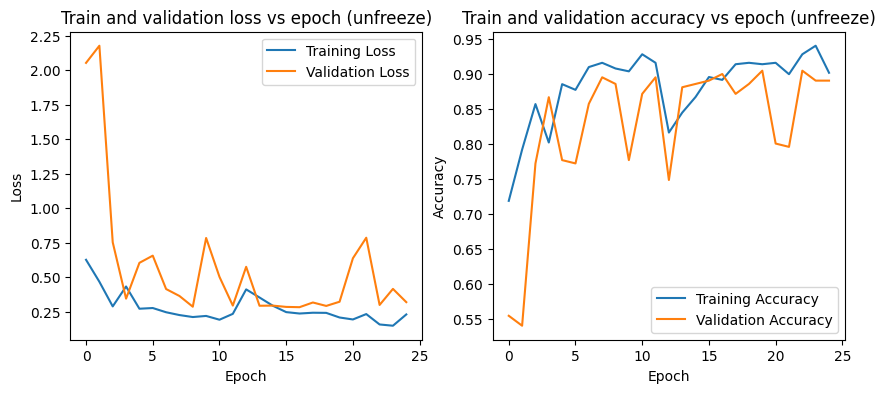

In [ ]:
# Evaluate the model using test set
test_loss, test_acc = vgg16_model_aug.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}\nTest loss: {test_loss}')

# Plot the loss and accuracy per epoch for train and validation set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(history_vgg16_aug.history['loss'], label='Training Loss')
axes[0].plot(history_vgg16_aug.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title("Train and validation loss vs epoch (unfreeze)")
axes[0].legend()

axes[1].plot(history_vgg16_aug.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_vgg16_aug.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title("Train and validation accuracy vs epoch (unfreeze)")
axes[1].legend()

plt.show()

As we can see based on training history in unfreezed training:
- Training accuracy is about 94% at best.
- Validation accuracy is about 90% at best.
- Test accuracy is also about 93%.

So the overall accuracy has increased this time.

For furture analysis, by augmentation, we will have about 250,000 data as training set.

$$ M = batch\_size\times Iterations \times N$$

where N is the number of main training data and M is the final number of training data.

### Original Data VGG16

#### Freezed VGG16

- First we freeze the base vgg16 part of the model again.
- define the model this time using original data to train it.

In [ ]:
vgg16_base.trainable = False
vgg16_model = Model(inputs=vgg16_base.input, outputs=FC_out_vgg16)

vgg16_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

At first, we compile the model:
- Optimizer: optimizer is set to SGD with defined parameters as the article. 
    - learning rate = 0.1
    - momentum = 0.9
    - learning rate decay = 0.002
- loss: the loss function is set to binary cross entropy.
    - loss function is set to categorical cross entropy, but as the target values are binary, so the binary cross entropy would be a better loss function.
- metrics: accuracy.

Then we train the model:
- The iput data is the original data.
- number of epochs,
- batch size,
- and validation set is given.

In [ ]:
# Compile the model
vgg16_model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum, decay=lr_decay),
                         loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_vgg16 = vgg16_model.fit(X_train, y_train, epochs=num_epochs,
                                validation_data=(X_val, y_val),
                                batch_size=batch_size)

Epoch 1/25
50/50 [==============================] - 6s 94ms/step - loss: 0.2075 - accuracy: 0.9226 - val_loss: 0.4218 - val_accuracy: 0.8341
Epoch 2/25
50/50 [==============================] - 4s 79ms/step - loss: 0.1488 - accuracy: 0.9369 - val_loss: 0.3036 - val_accuracy: 0.9005
Epoch 3/25
50/50 [==============================] - 4s 76ms/step - loss: 0.1975 - accuracy: 0.9185 - val_loss: 0.2655 - val_accuracy: 0.8815
Epoch 4/25
50/50 [==============================] - 4s 80ms/step - loss: 0.2009 - accuracy: 0.9287 - val_loss: 0.2750 - val_accuracy: 0.9005
Epoch 5/25
50/50 [==============================] - 4s 80ms/step - loss: 0.1785 - accuracy: 0.9328 - val_loss: 0.2775 - val_accuracy: 0.8957
Epoch 6/25
50/50 [==============================] - 4s 76ms/step - loss: 0.1554 - accuracy: 0.9430 - val_loss: 0.3098 - val_accuracy: 0.9005
Epoch 7/25
50/50 [==============================] - 4s 80ms/step - loss: 0.1818 - accuracy: 0.9389 - val_loss: 0.3426 - val_accuracy: 0.9005
Epoch 8/25
50

4/4 [==============================] - 1s 103ms/step - loss: 0.2721 - accuracy: 0.9300
Test accuracy: 0.9300000071525574
Test loss: 0.27207162976264954


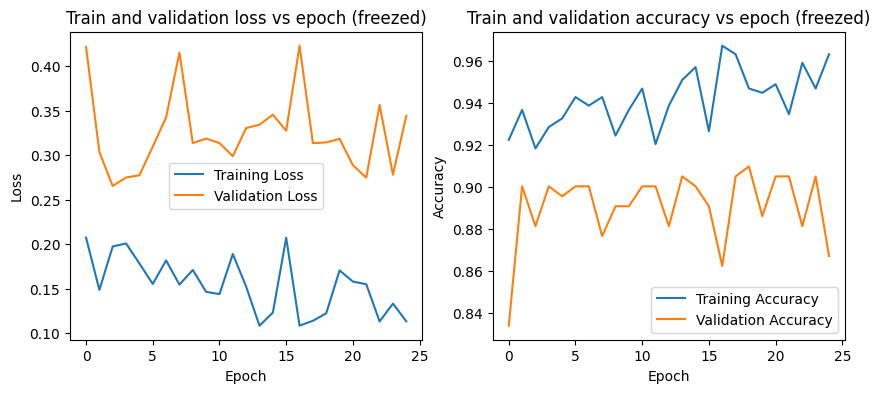

In [ ]:
# Evaluate the model using test set
test_loss, test_acc = vgg16_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}\nTest loss: {test_loss}')

# Plot the loss and accuracy per epoch for train and validation set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(history_vgg16.history['loss'], label='Training Loss')
axes[0].plot(history_vgg16.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title("Train and validation loss vs epoch (freezed)")
axes[0].legend()

axes[1].plot(history_vgg16.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title("Train and validation accuracy vs epoch (freezed)")
axes[1].legend()

plt.show()

- As we can see, based on the plots, the model is begining to overfit, which was obvious.
- This is the reseaon for data augmentation, to prevent overfitting.
- We got about 97% accuracy at best for training data.
- about 91% for validation data.
- and 93% for test.

#### Unfreezed last CONV block

- This time, unfreeze the last convolutional block and then train the model again.
- So that fine-tuning the model will be completed.
- And the model can be used for out task

In [ ]:
k = 0
for layer in vgg16_model.layers:
    if k == 1:
        layer.trainable = True

    elif layer.name.startswith('block5'):
        k = 1

    else:
        layer.trainable = False

vgg16_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

At first, we compile the model:
- Optimizer: optimizer is set to SGD with defined parameters as the article. 
    - learning rate = 0.1
    - momentum = 0.9
    - learning rate decay = 0.002
- loss: the loss function is set to binary cross entropy.
    - loss function is set to categorical cross entropy, but as the target values are binary, so the binary cross entropy would be a better loss function.
- metrics: accuracy.

Then we train the model:
- The iput data is the original data.
- number of epochs,
- batch size,
- and validation set is given.

In [ ]:
# Compile the model
vgg16_model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum, decay=lr_decay),
                         loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_vgg16 = vgg16_model.fit(X_train, y_train, epochs=num_epochs,
                                validation_data=(X_val, y_val),
                                batch_size=batch_size)

Epoch 1/25
50/50 [==============================] - 6s 98ms/step - loss: 0.2184 - accuracy: 0.9226 - val_loss: 0.5619 - val_accuracy: 0.7441
Epoch 2/25
50/50 [==============================] - 4s 85ms/step - loss: 0.1440 - accuracy: 0.9389 - val_loss: 0.5292 - val_accuracy: 0.8578
Epoch 3/25
50/50 [==============================] - 4s 87ms/step - loss: 0.1878 - accuracy: 0.9348 - val_loss: 0.6368 - val_accuracy: 0.8104
Epoch 4/25
50/50 [==============================] - 4s 85ms/step - loss: 0.1923 - accuracy: 0.9226 - val_loss: 0.4750 - val_accuracy: 0.8104
Epoch 5/25
50/50 [==============================] - 4s 82ms/step - loss: 0.1580 - accuracy: 0.9430 - val_loss: 2.5247 - val_accuracy: 0.6256
Epoch 6/25
50/50 [==============================] - 4s 88ms/step - loss: 0.1193 - accuracy: 0.9633 - val_loss: 0.5886 - val_accuracy: 0.8720
Epoch 7/25
50/50 [==============================] - 4s 83ms/step - loss: 0.1111 - accuracy: 0.9552 - val_loss: 0.5081 - val_accuracy: 0.8768
Epoch 8/25
50

4/4 [==============================] - 0s 93ms/step - loss: 0.4516 - accuracy: 0.9200
Test accuracy: 0.9200000166893005
Test loss: 0.451648473739624


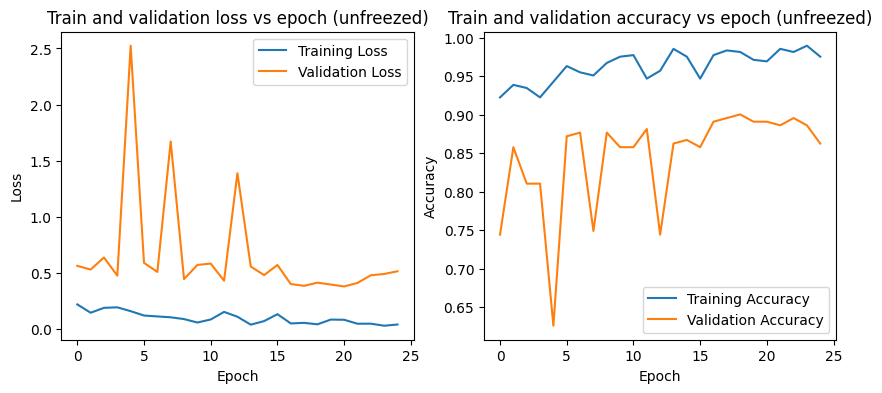

In [ ]:
# Evaluate the model using test set
test_loss, test_acc = vgg16_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}\nTest loss: {test_loss}')

# Plot the loss and accuracy per epoch for train and validation set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(history_vgg16.history['loss'], label='Training Loss')
axes[0].plot(history_vgg16.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title("Train and validation loss vs epoch (unfreezed)")
axes[0].legend()

axes[1].plot(history_vgg16.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title("Train and validation accuracy vs epoch (unfreezed)")
axes[1].legend()

plt.show()

- As we can see, based on the plots, the model has overfited obviously.
- This is the reseaon for data augmentation, to prevent overfitting.
- We got about 99% accuracy at best for training data.
- about 90% for validation data.
- and 92% for test.

Which is a bit worse than the model trained with augmented data.

## ResNet50

- ResNet50 is imported as a backbone model.

In [137]:
from keras.applications import ResNet50

Set the hyperparameters as in the article.
- learning rate = 0.1
- batch size = 10
- number of epochs = 25
- momentum = 0.9
- learning rate decay = 0.002

I have set number of epochs to **25**, so that run freezed and unfreezed model each with 25 epochs (50 epochs in total).

In [138]:
# Define hyperparameters
lr = 0.1
batch_size = 10
num_epochs = 25
momentum = 0.9
lr_decay = 0.002

This the defenition of the model we are defining with ResNet50 as ity's backbone:

- VGG16 itself gets the normalized data with specifice size. (the fully connected isn't included)
- Global Max Pooling the output of last convolutional block of ResNet50 to flat the data.
- Batch Normalization.
- A dense layer with 512 neurons inside. Activation function is set to **ReLU**.
- Dropout with 10% rate.
- The output layer contating only one neuron. Activation function is set to **Sigmoid**.

In [152]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add fully connected layers
x = GlobalMaxPooling2D()(resnet_base.output)
x = BatchNormalization()(x)
# x = Dropout(0.1)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
# x = Dense(16, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.1)(x)
FC_out_resnet = Dense(1, activation='sigmoid')(x)

### Augmented Data ResNet50

#### Freezed ResNet50

- Freeze the base ResNet50 model.
- Define the model.
- As we can see, this model have 24,647,553 parameters in total.
- The added fully connected part have 1,054,721 parameters.

In [153]:
resnet_base.trainable = False
# Create the new model
resnet_model_aug = Model(inputs=resnet_base.input, outputs=FC_out_resnet)

resnet_model_aug.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_15[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

At first, we compile the model:
- Optimizer: optimizer is set to SGD with defined parameters as the article. 
    - learning rate = 0.1
    - momentum = 0.9
    - learning rate decay = 0.002
- loss: the loss function is set to binary cross entropy.
    - loss function is set to categorical cross entropy, but as the target values are binary, so the binary cross entropy would be a better loss function.
- metrics: accuracy.

Then we train the model:
- The iput data is the augmented data using `ImageDataGenerator`.
- number of epochs,
- batch size,
- and validation set is given.

In [154]:
# Compile the model
resnet_model_aug.compile(optimizer=SGD(learning_rate=lr, momentum=momentum, decay=lr_decay),
                         loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_resnet_aug = resnet_model_aug.fit(augmentation, epochs=num_epochs,
                                         validation_data=(X_val, y_val),
                                         batch_size=batch_size)

Epoch 1/25
50/50 [==============================] - 15s 211ms/step - loss: 5.9315 - accuracy: 0.5540 - val_loss: 59.2551 - val_accuracy: 0.4976
Epoch 2/25
50/50 [==============================] - 8s 162ms/step - loss: 2.7748 - accuracy: 0.5499 - val_loss: 2.5292 - val_accuracy: 0.5166
Epoch 3/25
50/50 [==============================] - 7s 142ms/step - loss: 1.1214 - accuracy: 0.5580 - val_loss: 1.0675 - val_accuracy: 0.5118
Epoch 4/25
50/50 [==============================] - 9s 175ms/step - loss: 0.8088 - accuracy: 0.5927 - val_loss: 0.8870 - val_accuracy: 0.5024
Epoch 5/25
50/50 [==============================] - 7s 135ms/step - loss: 0.7399 - accuracy: 0.5336 - val_loss: 0.7092 - val_accuracy: 0.5308
Epoch 6/25
50/50 [==============================] - 8s 168ms/step - loss: 0.6386 - accuracy: 0.6721 - val_loss: 0.6618 - val_accuracy: 0.5782
Epoch 7/25
50/50 [==============================] - 8s 159ms/step - loss: 0.6525 - accuracy: 0.6456 - val_loss: 0.6287 - val_accuracy: 0.6398
Epoc

4/4 [==============================] - 0s 74ms/step - loss: 0.6439 - accuracy: 0.6500
Test accuracy: 0.6499999761581421
Test loss: 0.6438571214675903


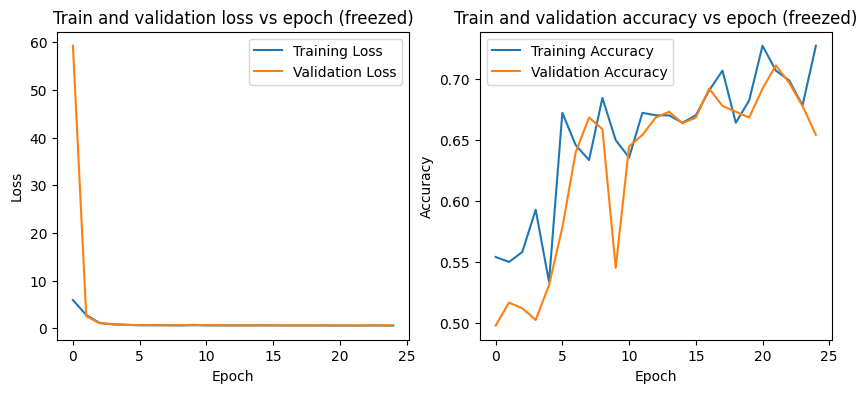

In [155]:
# Evaluate the model using test set
test_loss, test_acc = resnet_model_aug.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}\nTest loss: {test_loss}')

# Plot the loss and accuracy per epoch for train and validation set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(history_resnet_aug.history['loss'], label='Training Loss')
axes[0].plot(history_resnet_aug.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title("Train and validation loss vs epoch (freezed)")
axes[0].legend()

axes[1].plot(history_resnet_aug.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_resnet_aug.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title("Train and validation accuracy vs epoch (freezed)")
axes[1].legend()

plt.show()

As we can see based on training history in freeze training:
- Training accuracy is about 72.7% at best.
- Validation accuracy is about 71% at best.
- Test accuracy is also about 65%.

#### Unfreezed last CONV block

- This time, unfreeze the last convolutional block and then train the model again.
- So that fine-tuning the model will be completed.
- And the model can be used for out task.

In [156]:
k = 0
for layer in resnet_model_aug.layers:
    if k == 1:
        layer.trainable = True

    elif layer.name.startswith('conv5_block3'):
        k = 1

    else:
        layer.trainable = False

resnet_model_aug.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_15[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

At first, we compile the model:
- Optimizer: optimizer is set to SGD with defined parameters as the article. 
    - learning rate = 0.1
    - momentum = 0.9
    - learning rate decay = 0.002
- loss: the loss function is set to binary cross entropy.
    - loss function is set to categorical cross entropy, but as the target values are binary, so the binary cross entropy would be a better loss function.
- metrics: accuracy.

Then we train the model:
- The iput data is the augmented data using `ImageDataGenerator`.
- number of epochs,
- batch size,
- and validation set is given.

In [157]:
# Compile the model
resnet_model_aug.compile(optimizer=SGD(learning_rate=lr, momentum=momentum, decay=lr_decay),
                         loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_resnet_aug = resnet_model_aug.fit(augmentation, epochs=num_epochs,
                                          validation_data=(X_val, y_val),
                                          batch_size=batch_size)

Epoch 1/25
50/50 [==============================] - 14s 206ms/step - loss: 0.7202 - accuracy: 0.5784 - val_loss: 1.1203 - val_accuracy: 0.5024
Epoch 2/25
50/50 [==============================] - 7s 143ms/step - loss: 0.6733 - accuracy: 0.5642 - val_loss: 0.7185 - val_accuracy: 0.5118
Epoch 3/25
50/50 [==============================] - 7s 133ms/step - loss: 0.6591 - accuracy: 0.6314 - val_loss: 0.8164 - val_accuracy: 0.5024
Epoch 4/25
50/50 [==============================] - 9s 176ms/step - loss: 0.6621 - accuracy: 0.6029 - val_loss: 5.0615 - val_accuracy: 0.4976
Epoch 5/25
50/50 [==============================] - 7s 149ms/step - loss: 0.6374 - accuracy: 0.6293 - val_loss: 3.8839 - val_accuracy: 0.4976
Epoch 6/25
50/50 [==============================] - 7s 148ms/step - loss: 0.6669 - accuracy: 0.6130 - val_loss: 1.9628 - val_accuracy: 0.4976
Epoch 7/25
50/50 [==============================] - 8s 164ms/step - loss: 0.6413 - accuracy: 0.6334 - val_loss: 1.3372 - val_accuracy: 0.4976
Epoch

4/4 [==============================] - 0s 68ms/step - loss: 0.6176 - accuracy: 0.6700
Test accuracy: 0.6700000166893005
Test loss: 0.6176311373710632


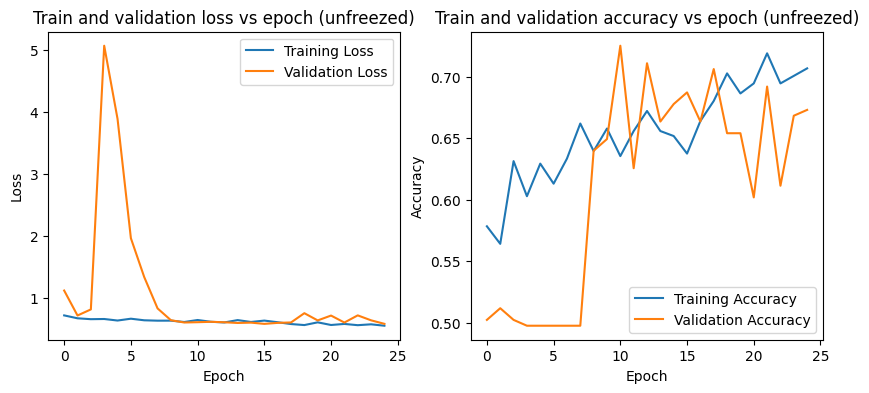

In [158]:
# Evaluate the model using test set
test_loss, test_acc = resnet_model_aug.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}\nTest loss: {test_loss}')

# Plot the loss and accuracy per epoch for train and validation set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(history_resnet_aug.history['loss'], label='Training Loss')
axes[0].plot(history_resnet_aug.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title("Train and validation loss vs epoch (unfreezed)")
axes[0].legend()

axes[1].plot(history_resnet_aug.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_resnet_aug.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title("Train and validation accuracy vs epoch (unfreezed)")
axes[1].legend()

plt.show()

As we can see based on training history in unfreezed training:
- Training accuracy is about 72% at best.
- Validation accuracy is about 70% at best.
- Test accuracy is also about 67%.

So the overall accuracy has increased this time.

For furture analysis, by augmentation, we will have about 250,000 data as training set.

$$ M = batch\_size\times Iterations \times N$$

where N is the number of main training data and M is the final number of training data.

### Original Data ResNet50

#### Freezed ResNet50

- First we freeze the base ResNet50 part of the model again.
- define the model this time using original data to train it.

In [140]:
# Create the new model
resnet_base.trainable = False
resnet_model = Model(inputs=resnet_base.input, outputs=FC_out_resnet)

resnet_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_14[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

At first, we compile the model:
- Optimizer: optimizer is set to SGD with defined parameters as the article. 
    - learning rate = 0.1
    - momentum = 0.9
    - learning rate decay = 0.002
- loss: the loss function is set to binary cross entropy.
    - loss function is set to categorical cross entropy, but as the target values are binary, so the binary cross entropy would be a better loss function.
- metrics: accuracy.

Then we train the model:
- The iput data is the original data.
- number of epochs,
- batch size,
- and validation set is given.

In [141]:
# Compile the model
resnet_model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum, decay=lr_decay),
                         loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_resnet = resnet_model.fit(X_train, y_train, epochs=num_epochs,
                                  validation_data=(X_val, y_val),
                                  batch_size=batch_size)

Epoch 1/25
50/50 [==============================] - 8s 104ms/step - loss: 4.7468 - accuracy: 0.5804 - val_loss: 16.5601 - val_accuracy: 0.5213
Epoch 2/25
50/50 [==============================] - 3s 61ms/step - loss: 3.5581 - accuracy: 0.6314 - val_loss: 1.6553 - val_accuracy: 0.5498
Epoch 3/25
50/50 [==============================] - 2s 50ms/step - loss: 0.9152 - accuracy: 0.6864 - val_loss: 0.9078 - val_accuracy: 0.5308
Epoch 4/25
50/50 [==============================] - 3s 61ms/step - loss: 0.7075 - accuracy: 0.7067 - val_loss: 0.9806 - val_accuracy: 0.4597
Epoch 5/25
50/50 [==============================] - 3s 64ms/step - loss: 0.5001 - accuracy: 0.7617 - val_loss: 0.6998 - val_accuracy: 0.6303
Epoch 6/25
50/50 [==============================] - 3s 62ms/step - loss: 0.5123 - accuracy: 0.7780 - val_loss: 0.6736 - val_accuracy: 0.6635
Epoch 7/25
50/50 [==============================] - 3s 50ms/step - loss: 0.5238 - accuracy: 0.7597 - val_loss: 0.7568 - val_accuracy: 0.6635
Epoch 8/25


4/4 [==============================] - 0s 77ms/step - loss: 1.3752 - accuracy: 0.5800
Test accuracy: 0.5799999833106995
Test loss: 1.375165581703186


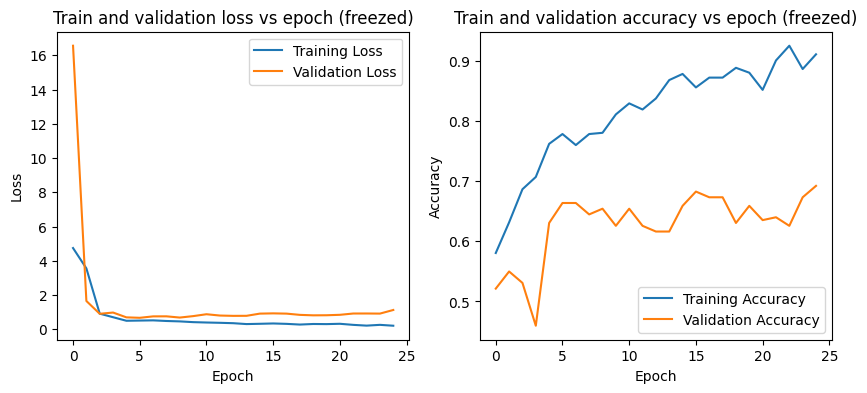

In [142]:
# Evaluate the model using test set
test_loss, test_acc = resnet_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}\nTest loss: {test_loss}')

# Plot the loss and accuracy per epoch for train and validation set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(history_resnet.history['loss'], label='Training Loss')
axes[0].plot(history_resnet.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title("Train and validation loss vs epoch (freezed)")
axes[0].legend()

axes[1].plot(history_resnet.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title("Train and validation accuracy vs epoch (freezed)")
axes[1].legend()

plt.show()

- As we can see, based on the plots, the model is begining to overfit, which was obvious.
- This is the reseaon for data augmentation, to prevent overfitting.
- We got about 91% accuracy at best for training data.
- about 70% for validation data.
- and 58% for test.

#### Unfreezed last CONV block

- This time, unfreeze the last convolutional block and then train the model again.
- So that fine-tuning the model will be completed.
- And the model can be used for out task.

In [143]:
k = 0
for layer in resnet_model.layers:
    if k == 1:
        layer.trainable = True

    elif layer.name.startswith('conv5_block3'):
        k = 1

    else:
        layer.trainable = False

resnet_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_14[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

At first, we compile the model:
- Optimizer: optimizer is set to SGD with defined parameters as the article. 
    - learning rate = 0.1
    - momentum = 0.9
    - learning rate decay = 0.002
- loss: the loss function is set to binary cross entropy.
    - loss function is set to categorical cross entropy, but as the target values are binary, so the binary cross entropy would be a better loss function.
- metrics: accuracy.

Then we train the model:
- The iput data is the original data.
- number of epochs,
- batch size,
- and validation set is given.

In [144]:
# Compile the model
resnet_model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum, decay=lr_decay),
                         loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_resnet = resnet_model.fit(X_train, y_train, epochs=num_epochs,
                                  validation_data=(X_val, y_val),
                                  batch_size=batch_size)

Epoch 1/25
50/50 [==============================] - 9s 107ms/step - loss: 0.9921 - accuracy: 0.5397 - val_loss: 4.4124 - val_accuracy: 0.5024
Epoch 2/25
50/50 [==============================] - 3s 68ms/step - loss: 0.6487 - accuracy: 0.6456 - val_loss: 1.7727 - val_accuracy: 0.5024
Epoch 3/25
50/50 [==============================] - 3s 66ms/step - loss: 0.6428 - accuracy: 0.6477 - val_loss: 0.6622 - val_accuracy: 0.6398
Epoch 4/25
50/50 [==============================] - 3s 66ms/step - loss: 0.6101 - accuracy: 0.6802 - val_loss: 0.6705 - val_accuracy: 0.5498
Epoch 5/25
50/50 [==============================] - 3s 57ms/step - loss: 0.6170 - accuracy: 0.6701 - val_loss: 3.8874 - val_accuracy: 0.5024
Epoch 6/25
50/50 [==============================] - 3s 54ms/step - loss: 0.6263 - accuracy: 0.6701 - val_loss: 1.3488 - val_accuracy: 0.5024
Epoch 7/25
50/50 [==============================] - 3s 66ms/step - loss: 0.5787 - accuracy: 0.7189 - val_loss: 1.6705 - val_accuracy: 0.5024
Epoch 8/25
5

4/4 [==============================] - 0s 71ms/step - loss: 1.3323 - accuracy: 0.5300
Test accuracy: 0.5299999713897705
Test loss: 1.3322871923446655


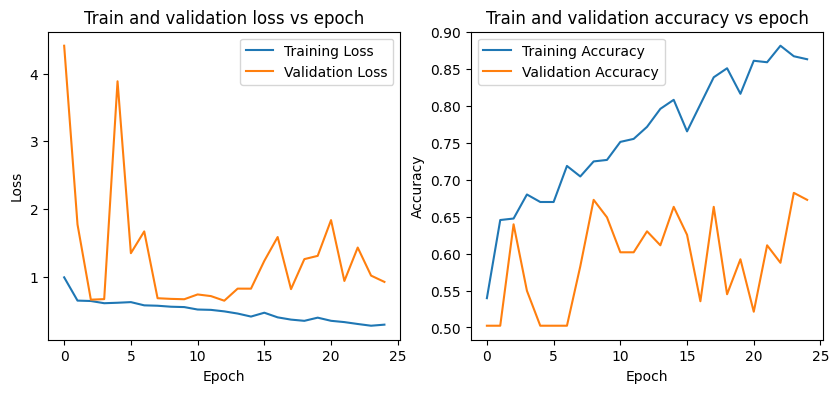

In [145]:
# Evaluate the model using test set
test_loss, test_acc = resnet_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}\nTest loss: {test_loss}')

# Plot the loss and accuracy per epoch for train and validation set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(history_resnet.history['loss'], label='Training Loss')
axes[0].plot(history_resnet.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title("Train and validation loss vs epoch")
axes[0].legend()

axes[1].plot(history_resnet.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title("Train and validation accuracy vs epoch")
axes[1].legend()

plt.show()

- As we can see, based on the plots, the model has overfited obviously.
- This is the reseaon for data augmentation, to prevent overfitting.
- We got about 90% accuracy at best for training data.
- about 67% for validation data.
- and 53% for test.

Which is worse than the model trained with augmented data.